<a href="https://www.kaggle.com/code/leonanvasconcelos/object-detection-with-pure-computer-vision?scriptVersionId=211373957" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Requirements

### **Scenario Description: Automated Fruit Detection and Analysis in Agricultural Imaging**
""**Objective:**  
Develop an automated system for detecting, counting, and analyzing round objects (such as fruitgs using advanced image processing and computer vision techniques. This system aims to enhance yield estimation, monitor crop health, and optimize harvesting processes by leveraging high-resolution images captured from various sources like drones or ground-based cameras.

**Workflow:**

1. **Image Acquisition:**
   - **Data Collection:** Utilize drones, satellite imagery, or fixed cameras to capture high-resolution images of orchards, plantations, or fruit-bearing areas. Ensure consistent lighting conditions and optimal angles to facilitate accurate detection.
   - **Image Input Options:** Support both direct image file paths (`path_image`) and Base64-encoded image strings (`image64`) to provide flexibility in data sourcing.

2. **Preprocessing:**
   - **Resizing:** Use `resize_image` to standardize image dimensions, ensuring uniformity across different datasets and optimizing processing speed without losing critical details.
   - **Aspect Ratio Adjustment:** Apply `crop_image_to_aspect_ratio` to maintain desired aspect ratios (e.g., 4:3 or 3:4) based on image orientation, enhancing the focus on relevant regions.

3. **Image Enhancement:**
   - **Contrast Enhancement:** Implement `apply_clahe` to improve image contrast adaptively, making fruits more distinguishable from the background.
   - **Color Smoothing:** Utilize `smooth_color` to reduce color noise and enhance the clarity of fruit regions, facilitating better segmentation.

4. **Color Filtering and Mask Generation:**
   - **Color Space Conversion:** Convert images to appropriate color spaces (HSV or LAB) using OpenCV's `cvtColor` for effective color-based segmentation.
   - **Color Range Selection:** Employ `filter_color` to isolate target fruits based on predefined color ranges, generating binary masks that highlight potential fruit regions.
   - **Morphological Operations:** Apply functions like `remove_salt_and_pepper`, `close_mask_circle`, and `expand_mask_circle` to refine masks by eliminating noise, closing gaps, and expanding regions to cover entire fruits.

5. **Foreground and Background Segmentation:**
   - **Foreground Masking:** Combine multiple masks using weighted summation to create a comprehensive foreground mask that accurately represents fruit regions.
   - **Background Masking:** Invert the foreground mask to delineate background areas, enabling separate processing if needed.

6. **Object Detection:**
   - **Circle Detection:** Utilize `detect_circles` with OpenCV's `SimpleBlobDetector` to identify circular shapes corresponding to fruits. Parameters like circularity, convexity, and inertia ratio are fine-tuned to enhance detection accuracy.
   - **Overlap Handling:** Implement `remove_overlapping_circles` to eliminate duplicate detections and ensure each fruit is counted only once.
   - **Visualization:** Use `draw_circles` to annotate detected fruits on the original image, providing visual confirmation and aiding in result verification.

7. **K-Means Clustering (Optional):**
   - **Color Quantization:** Apply `kmeans_recolor` to reduce the color palette of the image, simplifying color variations and potentially improving detection performance in complex backgrounds.
   - **Visualization:** Generate clustered images to analyze color distributions and adjust clustering parameters as needed.

8. **EXIF Metadata Extraction:**
   - **Metadata Retrieval:** Use `extract_metadata_EXIF` to obtain valuable information such as GPS coordinates, capture date, camera model, and manufacturer from image metadata.
   - **Data Integration:** Incorporate EXIF data into the final report for contextual insights, enabling spatial and temporal analysis of fruit distribution and growth patterns.

9. **Post-processing and Reporting:**
   - **Result Compilation:** Aggregate detection results, including the number of fruits detected and accuracy metrics, into a structured JSON format using `format_result`.
   - **Image Saving:** Save annotated images with detection overlays and preprocessed images for record-keeping and further analysis using `save_image`.
   - **Interactive Tuning (Debugging):** Provide functions like `tunning_blur`, `tunning_color`, and `tunning_BlobCircles` with OpenCV trackbars for real-time parameter adjustments, facilitating optimization during development and deployment.

10. **Batch Processing and Automation:**
    - **Batch Mode Support:** Enable processing of multiple images in a directory through the `test_directory` function, automating the detection pipeline and generating summarized accuracy reports.
    - **Error Handling:** Implement robust error handling to manage issues like invalid image paths, decoding errors, and missing EXIF data, ensuring the system's resilience and reliability.

**Benefits:**

- **Efficiency:** Automates the time-consuming process of fruit counting and analysis, allowing farmers and agricultural professionals to focus on decision-making and field operations.
- **Accuracy:** Enhances detection precision through advanced filtering, morphological operations, and customizable parameters, reducing human error and ensuring reliable yield estimates.
- **Scalability:** Capable of handling large datasets from extensive agricultural fields, supporting scalability as operations grow.
- **Flexibility:** Accommodates various image input formats and sources, providing versatility in data acquisition and integration.
- **Insightful Reporting:** Integrates EXIF metadata and detailed JSON reports, offering comprehensive insights into fruit distribution, environmental conditions, and system performance.
- **User-Friendly Tuning:** Interactive tuning functions enable users to adjust parameters on-the-fly, tailoring the system to specific agricultural contexts and improving adaptability to different fruit types and environments.
- **Cost-Effective:** Reduces the need for manual labor in fruit counting and monitoring, lowering operational costs and increasing overall productivity.

By implementing this comprehensive system, agricultural stakeholders can achieve enhanced monitoring of crop yields, better resource allocation, and informed strategies for crop management, ultimately contributing to increased agricultural efficiency and sustainability.
"""

In [234]:
# Requirements

from PIL import Image as PILImage
import os, random, io, base64, json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


#!jupyter nbextension install --py widgetsnbextension
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter nbextension enable --py widgetsnbextension
!jupyter labextension enable @jupyter-widgets/jupyterlab-manager

import ipywidgets as widgets

VERSION='2024/dec/04 3'

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
# Utils: functions created by the author

!git clone https://github.com/LeonanUCM/ObjectDetectionPureCV.git

Cloning into 'ObjectDetectionPureCV'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 29 (delta 0), reused 2 (delta 0), pack-reused 26 (from 1)
Unpacking objects: 100% (29/29), 79.87 MiB | 13.45 MiB/s, done.


In [236]:
# Redefine functions to work in Jupyter Notebook, not windows

def show_mosaic(images, headers=[""], footers=[""], window_name="Mosaic", mosaic_dims=(0, 0), max_resolution=1200):
    """
    Displays a mosaic of multiple images with optional headers and footers in a Jupyter Notebook.
    
    **Scenario:**
    In fruit detection, visualizing different stages of image processing (e.g., original, masked, segmented) side by side 
    helps in assessing the effectiveness of each processing step.
    
    **Logic and Computer Vision Methods:**
    The function utilizes the build_mosaic function to arrange images in a grid layout, optionally adding headers and footers
    for each column. It resizes images to fit within a specified maximum resolution and ensures that all images are in color 
    format before creating the mosaic.

    Args:
        images (list or numpy.ndarray): A list of images to include in the mosaic.
        headers (list of str, optional): Optional headers for each column in the mosaic. Default is [""]. 
        footers (list of str, optional): Optional footers for each column in the mosaic. Default is [""]. 
        window_name (str, optional): The name of the mosaic (used only for labeling). Default is "Mosaic".
        mosaic_dims (tuple, optional): The dimensions of the mosaic grid as (rows, columns). Default is (0, 0).
        max_resolution (int, optional): The maximum resolution for resizing images before creating the mosaic. Default is 1200.

    Returns:
        None
    """
    # Build the mosaic using the provided images and parameters.
    mosaic = build_mosaic(
        images,
        mosaic_dims=mosaic_dims,
        headers=headers,
        footers=footers,
        max_resolution=max_resolution
    )
    
    # Display the mosaic in a Jupyter Notebook.
    plt.figure(figsize=(10, 10))
    plt.imshow(mosaic)  # Convert from BGR to RGB for correct color display
    plt.axis('off')  # Turn off axis
    plt.title(window_name, fontsize=16, fontweight='bold')  # Add title
    plt.show()




import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import cv2
import numpy as np

def tunning_texture(image, kernel_size=21, threshold_value=15, noise=3, expand=3, it=1):
    """
    Provides an interactive tool to tune texture detection parameters using Gaussian blur and thresholding in Jupyter Notebook.

    Args:
        image (numpy.ndarray): The input image in RGB color space.
        kernel_size (int, optional): The kernel size for the Gaussian blur. Must be odd. Default is 21.
        threshold_value (int, optional): The threshold value for detecting smooth areas. Default is 15.
        noise (int, optional): The kernel size for salt-and-pepper noise removal. Default is 3.
        expand (int, optional): The kernel size for mask dilation (expansion). Default is 3.
        it (int, optional): The number of iterations for mask expansion. Default is 1.

    Returns:
        tuple: A tuple containing the processed image, the mask, and the final parameter values.
    """
    def make_odd(value):
        """Ensure the value is odd."""
        return value if value % 2 == 1 else value + 1

    def display_images(img_before, img_after, mask):
        """Display images side by side."""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))
        axes[1].set_title('Mask')
        axes[1].axis('off')

        axes[2].imshow(cv2.cvtColor(img_after, cv2.COLOR_BGR2RGB))
        axes[2].set_title('Processed Image')
        axes[2].axis('off')

        plt.show()

    def update_texture(kernel_size, threshold_value, noise, expand, it):
        """Process the image with updated parameters."""
        nonlocal img_after, mask_tmp, final_kernel_size, final_threshold_value, final_noise, final_expand, final_it
        
        # Ensure kernel and noise sizes are odd
        kernel_size = make_odd(kernel_size)
        noise = make_odd(noise)
        expand = make_odd(expand)

        # Process the image
        img_tmp = img_before.copy()
        img_after, mask_tmp = detect_smooth_areas_rgb(
            img_tmp, 
            kernel_size=kernel_size, 
            threshold_value=threshold_value,
            noise=noise,
            expand=expand,
            it=it
        )

        # Save the final parameters
        final_kernel_size = kernel_size
        final_threshold_value = threshold_value
        final_noise = noise
        final_expand = expand
        final_it = it

        # Display the updated images
        display_images(img_before, img_after, mask_tmp)

    # Resize the image for processing
    img_before = resize_image(image, max_resolution=800)

    # Initialize results
    img_after = None
    mask_tmp = None
    final_kernel_size = kernel_size
    final_threshold_value = threshold_value
    final_noise = noise
    final_expand = expand
    final_it = it

    # Interactive widgets
    kernel_slider = widgets.IntSlider(value=kernel_size, min=1, max=251, step=2, description='Kernel Size')
    threshold_slider = widgets.IntSlider(value=threshold_value, min=0, max=255, description='Threshold')
    noise_slider = widgets.IntSlider(value=noise, min=1, max=29, step=2, description='Noise Size')
    expand_slider = widgets.IntSlider(value=expand, min=1, max=29, step=2, description='Expand Size')
    it_slider = widgets.IntSlider(value=it, min=1, max=10, description='Iterations')

    ui = widgets.VBox([kernel_slider, threshold_slider, noise_slider, expand_slider, it_slider])

    out = widgets.interactive_output(
        update_texture,
        {'kernel_size': kernel_slider, 'threshold_value': threshold_slider,
         'noise': noise_slider, 'expand': expand_slider, 'it': it_slider}
    )

    # Display widgets and output
    display(ui, out)

    # Wait for user adjustments (blocking mechanism isn't available in Jupyter)
    debug_print("Adjust the sliders above to tune the texture detection parameters. Once done, run the next cell to retrieve the results.")

    return lambda: (img_after, mask_tmp, final_kernel_size, final_threshold_value, final_noise, final_expand, final_it)


In [237]:
# Profile configuration

NOTEBOOK = True # specific functions that depending on environment (Windows of Notebook) are different

def load_config(profile):
    class Config:
        pass

    cfg = Config()

    cfg.profile = profile

    assert profile in ['ORANGE ', 'ORANGE ', 'APPLE ', 'APPLE ', 'YELLOW_PEACH ', 'YELLOW_PEACH ', 'RED_PEACH ', 'RED_PEACH '], \
    "Profile must be one of: 'ORANGE ', 'ORANGE ', 'APPLE ', 'APPLE ', 'YELLOW_PEACH ', 'YELLOW_PEACH ', 'RED_PEACH ', 'RED_PEACH "

    # Default configuration valid for all profiles, 
    # but can be redefined in the profile specific configuration
    cfg.max_resolution = 1536 # resolution of reduced image to be processed
    cfg.aspect_ratio = (4,3) # 4x3
    cfg.factor_contrast = 1
    cfg.resolution_returned = 2048 # resolution of original image returned
    cfg.expand_foreground = 13
    cfg.fill_holes = True
    cfg.color_list = []
    cfg.foreground_list = []
    cfg.color_list_name_weight = []
    cfg.quantization_n_colors = 10
    cfg.smooth_colors = 19
    cfg.texture_1_kernel_size, cfg.texture_1_threshold_value, cfg.texture_1_noise, cfg.texture_1_expand, cfg.texture_1_it = (1, 1, 1, 1, 3)
    cfg.texture_2_kernel_size, cfg.texture_2_threshold_value, cfg.texture_2_noise, cfg.texture_2_expand, cfg.texture_2_it = (1, 1, 1, 1, 3)
    cfg.texture_3_kernel_size, cfg.texture_3_threshold_value, cfg.texture_3_noise, cfg.texture_3_expand, cfg.texture_3_it = (1, 1, 1, 1, 3)
    cfg.texture_4_kernel_size, cfg.texture_4_threshold_value, cfg.texture_4_noise, cfg.texture_4_expand, cfg.texture_4_it = (1, 1, 1, 1, 3)
    cfg.smooth_mask_certain = 7


    # Load configuration depending on the cfg.profile
    if (cfg.profile == 'ORANGE '):
        # Profile: ORANGE 
        # Quality:
        cfg.quantization_n_colors, cfg.max_resolution, cfg.smooth_colors, cfg.factor_contrast = (0, 1536, 0, 1.05)

        # Blur:
        cfg.blur_clahe_grid, cfg.blur_clahe_limit, cfg.blur_salt_pepper, cfg.blur_size = (5, 2.1, 5, 5)

        # Amplify Saturation:
        cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase = (0, 0, 0)

        # Foreground selection:
        cfg.foreground_list.append([['Foreground Green', -1], [60, 20, 20, 316, 100, 100, 1, 15, 1, 1]])
        cfg.foreground_list.append([['Foreground Brown', -1], [0, 3, 8, 32, 39, 85, 1, 19, 1, 1]])
        cfg.foreground_list.append([['Foreground Probrably', 1], [5, 39, 29, 61, 100, 100, 43, 9, 5, 1]])
        cfg.foreground_list.append([['Foreground Certainly', 2], [18, 60, 60, 49, 100, 100, 47, 3, 1, 1]])

        # Texture Removal:
        cfg.texture_1_kernel_size, cfg.texture_1_threshold_value, cfg.texture_1_noise, cfg.texture_1_expand, cfg.texture_1_it = (29, 23, 1, 7, 1)
        cfg.texture_2_kernel_size, cfg.texture_2_threshold_value, cfg.texture_2_noise, cfg.texture_2_expand, cfg.texture_2_it = (3, 1, 1, 3, 1)
        cfg.texture_3_kernel_size, cfg.texture_3_threshold_value, cfg.texture_3_noise, cfg.texture_3_expand, cfg.texture_3_it = (1, 0, 1, 1, 0)
        cfg.texture_4_kernel_size, cfg.texture_4_threshold_value, cfg.texture_4_noise, cfg.texture_4_expand, cfg.texture_4_it = (1, 0, 1, 1, 0)

        # Object Selection
        cfg.color_list.append([['Object Low Intensity and Sat', -1], [40, 0, 0, 23, 40, 80, 7, 11, 1, 1]])
        cfg.color_list.append([['Object Probrably', 1], [16, 30, 35, 65, 100, 100, 25, 3, 3, 1]])
        cfg.color_list.append([['Object Certainly', 2], [16, 60, 70, 65, 100, 100, 33, 3, 3, 1]])
        cfg.smooth_mask_certain =  0

        # Circle Detection:
        cfg.circle_minCircularity, cfg.circle_minConvexity, cfg.circle_minInertiaRatio, = (0.4, 0.4, 0.5)
        cfg.circle_minArea, cfg.circle_maxArea =  (710, 12150)
        cfg.min_radius_circle, cfg.tolerance_overlap =  (34, 0.3)

    elif (cfg.profile == 'APPLE '):
        # Profile: APPLE 
        # Quality:
        cfg.quantization_n_colors, cfg.max_resolution, cfg.smooth_colors, cfg.factor_contrast = (0, 1536, 19, 0.98)

        # Blur:
        cfg.blur_clahe_grid, cfg.blur_clahe_limit, cfg.blur_salt_pepper, cfg.blur_size = (5, 0.7, 3, 5)

        # Amplify Saturation:
        cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase = (75, 10, 0.3)

        # Foreground selection:
        cfg.foreground_list.append([['Foreground Green', -1], [87, 20, 20, 316, 100, 100, 5, 11, 1, 1]])
        cfg.foreground_list.append([['Foreground Brown', -1], [325, 3, 5, 53, 41, 85, 3, 19, 1, 1]])
        cfg.foreground_list.append([['Foreground Probrably', 1], [50, 30, 40, 89, 100, 100, 31, 21, 7, 1]])
        cfg.foreground_list.append([['Foreground Certainly', 2], [61, 45, 50, 76, 100, 100, 41, 43, 7, 1]])

        # Texture Removal:
        cfg.texture_1_kernel_size, cfg.texture_1_threshold_value, cfg.texture_1_noise, cfg.texture_1_expand, cfg.texture_1_it = (57, 13, 1, 1, 1)   
        cfg.texture_2_kernel_size, cfg.texture_2_threshold_value, cfg.texture_2_noise, cfg.texture_2_expand, cfg.texture_2_it = (19, 11, 1, 1, 1)   
        cfg.texture_3_kernel_size, cfg.texture_3_threshold_value, cfg.texture_3_noise, cfg.texture_3_expand, cfg.texture_3_it = (33, 61, 1, 1, 1)   
        cfg.texture_4_kernel_size, cfg.texture_4_threshold_value, cfg.texture_4_noise, cfg.texture_4_expand, cfg.texture_4_it = (23, 15, 3, 1, 1)   

        # Object Selection
        cfg.color_list.append([['Object Low Intensity and Sat', -1], [0, 0, 0, 359, 50, 66, 1, 3, 1, 2]])
        cfg.color_list.append([['Object Probrably', 1], [41, 29, 36, 78, 100, 100, 39, 17, 1, 1]])
        cfg.color_list.append([['Object Certainly', 2], [56, 40, 75, 70, 100, 100, 27, 47, 7, 1]])
        cfg.smooth_mask_certain = 15

        # Circle Detection:
        cfg.circle_minCircularity, cfg.circle_minConvexity, cfg.circle_minInertiaRatio, = (0.4, 0.4, 0.5)
        cfg.circle_minArea, cfg.circle_maxArea =  (920, 12150)
        cfg.min_radius_circle, cfg.tolerance_overlap =  (34, 0.2)

    elif (cfg.profile == 'YELLOW_PEACH '):
        # Profile: YELLOW_PEACH 
        # Quality:
        cfg.quantization_n_colors, cfg.max_resolution, cfg.smooth_colors, cfg.factor_contrast = (0, 1536, 19, 0.98)

        # Blur:
        cfg.blur_clahe_grid, cfg.blur_clahe_limit, cfg.blur_salt_pepper, cfg.blur_size = (5, 2.5, 5, 5)

        # Amplify Saturation:
        cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase = (0, 0, 0)

        # Foreground selection:
        cfg.foreground_list.append([['Foreground Green', -1], [70, 30, 20, 316, 100, 100, 3, 15, 1, 1]])
        cfg.foreground_list.append([['Foreground Brown', -1], [0, 3, 8, 32, 39, 85, 1, 15, 1, 1]])
        cfg.foreground_list.append([['Foreground Probrably', 1], [36, 32, 37, 66, 100, 100, 27, 19, 11, 1]])
        cfg.foreground_list.append([['Foreground Certainly', 2], [27, 60, 60, 50, 100, 100, 37, 17, 5, 1]])

        # Texture Removal:
        cfg.texture_1_kernel_size, cfg.texture_1_threshold_value, cfg.texture_1_noise, cfg.texture_1_expand, cfg.texture_1_it = (29, 5, 1, 3, 1)    
        cfg.texture_2_kernel_size, cfg.texture_2_threshold_value, cfg.texture_2_noise, cfg.texture_2_expand, cfg.texture_2_it = (3, 11, 3, 3, 1)    
        cfg.texture_3_kernel_size, cfg.texture_3_threshold_value, cfg.texture_3_noise, cfg.texture_3_expand, cfg.texture_3_it = (5, 9, 1, 1, 0)     
        cfg.texture_4_kernel_size, cfg.texture_4_threshold_value, cfg.texture_4_noise, cfg.texture_4_expand, cfg.texture_4_it = (1, 0, 1, 1, 0)     

        # Object Selection
        cfg.color_list.append([['Object Low Intensity and Sat', -1], [40, 0, 0, 23, 30, 80, 5, 7, 1, 1]])
        cfg.color_list.append([['Object Probrably', 1], [16, 30, 35, 65, 100, 100, 25, 3, 3, 1]])
        cfg.color_list.append([['Object Certainly', 2], [16, 53, 35, 65, 100, 100, 25, 3, 3, 1]])
        cfg.smooth_mask_certain = 15

        # Circle Detection:
        cfg.circle_minCircularity, cfg.circle_minConvexity, cfg.circle_minInertiaRatio, = (0.4, 0.4, 0.5)
        cfg.circle_minArea, cfg.circle_maxArea =  (1110, 12380)
        cfg.min_radius_circle, cfg.tolerance_overlap =  (34, 0.1)
      
    elif (cfg.profile == 'RED_PEACH '):
        # Profile: RED_PEACH 
        # Quality:
        cfg.quantization_n_colors, cfg.max_resolution, cfg.smooth_colors, cfg.factor_contrast = (0, 1536, 19, 0.98)        

        # Blur:
        cfg.blur_clahe_grid, cfg.blur_clahe_limit, cfg.blur_salt_pepper, cfg.blur_size = (5, 2.5, 5, 3)

        # Amplify Saturation:
        cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase = (0, 0, 0)

        # Foreground selection:
        cfg.foreground_list.append([['Foreground Red LAB', 1], [20, 9, -25, 80, 127, 17, 11, 23, 1, 2]])
        cfg.foreground_list.append([['Foreground Yellow LAB', 1], [30, -25, 22, 85, 38, 85, 17, 19, 1, 2]])
        cfg.foreground_list.append([['Foreground Brown LAB', -1], [11, -8, 1, 100, 7, 27, 13, 7, 1, 5]])

        # Texture Removal:
        cfg.texture_1_kernel_size, cfg.texture_1_threshold_value, cfg.texture_1_noise, cfg.texture_1_expand, cfg.texture_1_it = (29, 5, 1, 3, 1)
        cfg.texture_2_kernel_size, cfg.texture_2_threshold_value, cfg.texture_2_noise, cfg.texture_2_expand, cfg.texture_2_it = (3, 11, 3, 3, 1)
        cfg.texture_3_kernel_size, cfg.texture_3_threshold_value, cfg.texture_3_noise, cfg.texture_3_expand, cfg.texture_3_it = (1, 0, 1, 1, 0)
        cfg.texture_4_kernel_size, cfg.texture_4_threshold_value, cfg.texture_4_noise, cfg.texture_4_expand, cfg.texture_4_it = (1, 0, 1, 1, 0)

        # Object Selection
        cfg.color_list.append([['Object Low Intensity and Sat', -3], [353, 0, 0, 30, 22, 75, 5, 7, 1, 1]])
        cfg.color_list.append([['Object Probrably Red', 1], [196, 20, 35, 17, 100, 100, 25, 21, 3, 1]])
        cfg.color_list.append([['Object Probrably Yellow', 1], [15, 20, 35, 70, 100, 100, 33, 21, 3, 1]])
        cfg.color_list.append([['Object Certainly Red', 2], [305, 37, 45, 20, 100, 100, 23, 17, 3, 1]])
        cfg.color_list.append([['Object Certainly Yelow', 2], [15, 53, 57, 60, 100, 100, 21, 21, 3, 1]])
        cfg.smooth_mask_certain =  15

        # Circle Detection:
        cfg.circle_minCircularity, cfg.circle_minConvexity, cfg.circle_minInertiaRatio, = (0.4, 0.4, 0.3)
        cfg.circle_minArea, cfg.circle_maxArea =  (580, 27180)
        cfg.min_radius_circle, cfg.tolerance_overlap =  (34, 0.4)

    else:
        raise Exception('Profile not found')    
    
    cfg.quantization_n_colors = 6

    return cfg


# Main

In [238]:
# count_round_objects()


def count_round_objects(path_image='', image64='', profile='ORANGE ', json_exif_str='', json_gps_str=''):
    """
    Processes an image to identify and outline round objects (e.g., fruits) through a series of image processing steps.

    **Scenario:**
    This function is particularly useful in agricultural settings where automated fruit counting and analysis are required.
    For example, farmers can use this function to estimate the yield of apple trees by analyzing images captured by drones.

    **Workflow Logic:**
    1. **Image Loading:**  
       - Accepts either a file path or a Base64-encoded string to load the image.
       - Converts the image to a NumPy array for processing.

    2. **EXIF Metadata Extraction:**  
       - Retrieves metadata such as GPS coordinates, capture date, device model, and manufacturer.
       - Incorporates this information into the result for contextual analysis.

    3. **Configuration Loading:**  
       - Loads color profiles and processing configurations based on the specified profile.
       - Ensures that the processing parameters are tailored to the specific color characteristics of the target objects.

    4. **Image Resizing and Aspect Ratio Adjustment:**  
       - Crops the image to maintain a desired aspect ratio, enhancing the focus on relevant regions.
       - Resizes the image to a maximum resolution to optimize processing speed without compromising essential details.

    5. **Color Smoothing:**  
       - Applies color smoothing to reduce noise and enhance the clarity of target objects.

    6. **Texture Removal:**  
       - Utilizes morphological operations to detect and remove textures that may interfere with object detection.
       - Processes multiple texture layers to ensure clean segmentation.

    7. **Color Amplification:**  
       - Enhances the saturation of specific hues to make target objects more distinguishable from the background.

    8. **Blurring and Contrast Adjustment:**  
       - Applies Contrast Limited Adaptive Histogram Equalization (CLAHE) for contrast enhancement.
       - Removes salt-and-pepper noise and applies Gaussian blur to further smooth the image.

    9. **Foreground Selection:**  
       - Combines multiple color filters to create a comprehensive mask highlighting the foreground objects.
       - Differentiates between certain and probable object regions for more accurate detection.

    10. **Quantization (Optional):**  
        - Applies K-Means clustering to reduce the color palette, simplifying color variations and potentially improving detection accuracy.

    11. **Circle Detection:**  
        - Detects circular shapes corresponding to target objects using blob detection techniques.
        - Handles overlapping detections to ensure each object is counted only once.

    12. **Result Compilation and Saving:**  
        - Draws detected circles on the original image for visualization.
        - Calculates accuracy metrics if ground truth data is available.
        - Saves the processed images and compiles the results into a JSON format for reporting.

    **Arguments:**
        path_image (str): Directory and filename of the image file (optional).
        image64 (str): Base64-encoded string of the image (optional).
        profile (str): Desired color profile for fruit detection (default is 'ORANGE ').
        json_exif_str (str): EXIF data of the image as a JSON-formatted string (optional).
        json_gps_str (str): GPS data of the image as a JSON-formatted string (optional).

    **Returns:**
        str: JSON-formatted string containing image dimensions, metadata, detection results, and other relevant information.
             If an error occurs, returns a JSON string with an error message.
    """
    
    debug_print(f'count_round_objects. version={VERSION}')

    # Ensure that only one of path_image or image64 is provided
    if (path_image == '' and image64 == '') or (path_image != '' and image64 != ''):
        debug_print('Parameters path_image and image64 are mutually exclusive and mandatory.')
        return '{"error": "error"}'

    debug_print(f'  json_exif_str={json_exif_str}')
    debug_print(f'  json_gps_str={json_gps_str}')

    # Load image from Base64 string (suitable for JavaScript, HTML, Ionic)
    debug_print('Trying to load image')
    if image64 != '':
        try:
            img_IO = PILImage.open(io.BytesIO(base64.b64decode(image64)))
        except:
            error = '{"error": "Error reading image in base64"}'
            debug_print(error)
            return error
    # Load image from file path (suitable for Python)
    else:
        try:
            img_IO = PILImage.open(path_image)
        except:
            error = '{"error": "Error reading file ' + path_image + '"}'
            debug_print(error)
            return error

    img_original = np.array(img_IO)
    result_json = { 'dimensions': f'{img_original.shape[0]}x{img_original.shape[1]}px'}

    # Read EXIF data (GPS, device...)
    result_exif = {}
    if extract_metadata_EXIF(img_IO, result_exif):
        debug_print(f"    EXIF: coordinates={result_exif.get('coordinates')}, date={result_exif.get('capture_date')}, model={result_exif.get('mobile_model')}, manufacturer={result_exif.get('mobile_manufacturer')}")
        result_json.update(result_exif)
    img_IO.close()

    file = path_image.split('/')[-1]
    directory = path_image.replace(file, '')

    #####################################################################################################
    debug_print(f'0. Loading configuration:')
    #####################################################################################################
    # Initialize the static configuration variable on the first call
    if not hasattr(count_round_objects, 'cfg'):
        debug_print(f'    Loading profile for first time: {profile}')
        count_round_objects.cfg = load_config(profile)
        
    cfg = count_round_objects.cfg
    if cfg.profile != profile:
        debug_print(f'    Loading new profile: {profile}')
        cfg = load_config(profile)

    #####################################################################################################
    debug_print(f'1. Resize:')
    #####################################################################################################

    images = [img_original]
    masks = []

    # Crop image to maintain desired aspect ratio
    if cfg.aspect_ratio == 0:
        debug_print('    Skipping cropping image to aspect ratio.')
    else:
        debug_print(f'    Cropping image to aspect ratio {cfg.aspect_ratio[0]}x{cfg.aspect_ratio[1]}:')
        img_crop = crop_image_to_aspect_ratio(images[-1], cfg.aspect_ratio)
        if img_original.shape != img_crop.shape:
            debug_print(f'    Original Size: {images[-1].shape}    New Size: {img_crop.shape}')
        images.append(img_crop)

    # Resize image to maximum resolution
    if cfg.max_resolution == 0:
        debug_print('    Skipping Resize')
    else:
        images.append(resize_image(images[-1], cfg.max_resolution))
        debug_print(f'    Original Size: {images[-2].shape}    New Size: {images[-1].shape}')

        if DEBUG_LEVEL >= 5:
            show_mosaic([images[-2], images[-1]], headers=['Original', 'Resized'], window_name='Original vs Resized')

    img_reduced = images[-1]

    #####################################################################################################
    debug_print(f'1.1. Smooth color:')
    #####################################################################################################

    img_before = images[-1].copy()
    img_tmp = img_before

    # Apply color smoothing if configured
    if cfg.smooth_colors == 0:
        debug_print('    Skipping Smooth Color')
    else:
        img_tmp = smooth_color(img_tmp, kernel_size=cfg.smooth_colors, min_brightness=20, max_brightness=210)
    
        if DEBUG_LEVEL >= 2:
            show_mosaic([img_before, img_tmp], 
                        mosaic_dims=(1, 2),
                        headers=['Before'],
                        footers=['Smoothed'],
                        window_name=f'Smooth color',
                        max_resolution=800)
            
            
    img_smooth_color = img_tmp
    images.append(img_tmp)

    #####################################################################################################
    debug_print(f'   Remove Texture 1:')
    #####################################################################################################

    # Remove texture using morphological operations if configured
    if cfg.texture_1_kernel_size <= 1:
        debug_print('   Skipping Texture 1')
    else:
        img_tmp = images[-1].copy()
        img_after = np.zeros_like(images[-1])
        mask_tmp = np.zeros_like(img_tmp)

        if TUNNING_TEXTURE:
            img_after, mask_tmp, cfg.texture_1_kernel_size, cfg.texture_1_threshold_value, \
            cfg.texture_1_noise, cfg.texture_1_expand, cfg.texture_1_it = \
            tunning_texture(img_tmp,
                            kernel_size=cfg.texture_1_kernel_size, 
                            threshold_value=cfg.texture_1_threshold_value,
                            noise=cfg.texture_1_noise,
                            expand=cfg.texture_1_expand,
                            it=cfg.texture_1_it)
            
        img_after, mask_tmp = detect_smooth_areas_rgb(img_tmp, 
                                        kernel_size=cfg.texture_1_kernel_size, 
                                        threshold_value=cfg.texture_1_threshold_value, 
                                        noise=cfg.texture_1_noise, 
                                        expand=cfg.texture_1_expand, 
                                        it=cfg.texture_1_it)
        
        images.append(img_after)
        masks.append(~mask_tmp)

    #####################################################################################################
    debug_print(f'1.2. Amplify Color:')
    #####################################################################################################
    # Amplify saturation around a specific hue to enhance target objects
    if cfg.color_amplify_range == 0:
        debug_print('    Skipping Amplify Color')
        img_amplified = images[-1].copy()
    else:
        img_tmp = images[-1].copy()
        img_amplified = amplify_saturation_near_hue(img_tmp, cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase)
        if DEBUG_LEVEL >= 4:
            show_mosaic([img_amplified, img_tmp], 
                        mosaic_dims=(1, 2),
                        headers=['Amplified'],
                        footers=['Original'], 
                        window_name='Amplify Saturation',
                        max_resolution=800)

        images.append(img_amplified)  

    #####################################################################################################
    debug_print(f'2. Blur:')
    #####################################################################################################

    img_tmp = images[-1].copy()

    # Interactive tuning of blur parameters if in debug mode
    if TUNNING_BLUR:
        _, cfg.blur_clahe_grid, cfg.blur_clahe_limit, cfg.blur_salt_pepper, cfg.blur_size = \
            tunning_blur(img_tmp, 
                        clahe_grid=cfg.blur_clahe_grid, 
                        clahe_limit=cfg.blur_clahe_limit, 
                        salt_pepper=cfg.blur_salt_pepper, 
                        blur_size=cfg.blur_size)

    # Apply CLAHE, remove noise, and apply Gaussian blur
    img_tmp = images[-1].copy()
    _, img_tmp, _ = apply_clahe(img_tmp, 
                                tileGridSize=(cfg.blur_clahe_grid, cfg.blur_clahe_grid), 
                                clipLimit=cfg.blur_clahe_limit)
    img_tmp = remove_salt_and_pepper(img_tmp, kernel_size=cfg.blur_salt_pepper)
    img_tmp = blur_image(img_tmp, kernel_size=cfg.blur_size)

    images.append(img_tmp.copy())
    img_blur = img_tmp.copy()
    del img_tmp

    debug_print(f'   Remove Texture 2:')

    # Remove additional texture layers if configured
    if cfg.texture_2_kernel_size <= 1:
        debug_print('   Skipping Texture 2')
    else:
        img_tmp = images[-1].copy()
        img_after = np.zeros_like(images[-1])
        mask_tmp = np.zeros_like(img_tmp)

        if TUNNING_TEXTURE:
            img_after, mask_tmp, cfg.texture_2_kernel_size, cfg.texture_2_threshold_value, \
            cfg.texture_2_noise, cfg.texture_2_expand, cfg.texture_2_it = \
            tunning_texture(img_tmp,
                            kernel_size=cfg.texture_2_kernel_size, 
                            threshold_value=cfg.texture_2_threshold_value,
                            noise=cfg.texture_2_noise,
                            expand=cfg.texture_2_expand,
                            it=cfg.texture_2_it)
        
        img_after, mask_tmp = detect_smooth_areas_rgb(img_tmp, 
                                        kernel_size=cfg.texture_2_kernel_size, 
                                        threshold_value=cfg.texture_2_threshold_value, 
                                        noise=cfg.texture_2_noise, 
                                        expand=cfg.texture_2_expand, 
                                        it=cfg.texture_2_it)
        
        images.append(img_after)
        masks.append(~mask_tmp)


    #####################################################################################################
    debug_print(f'3. Select Foreground')
    #####################################################################################################

    img_before = images[-1].copy()
    img_tmp = img_before
    mask_tmp = np.zeros(img_tmp.shape[:2], dtype=np.int8)

    # Iterate through the list of foreground colors to create masks
    for i in range(len(cfg.foreground_list)):
        cfg.foreground_name = cfg.foreground_list[i][0][0]
        cfg.foreground_weight = cfg.foreground_list[i][0][1]
        color_space = 'LAB' if 'LAB' in cfg.foreground_name else 'HSV'

        if cfg.foreground_weight != 0:
            if TUNNING_FOREGROUND:
                selected_area, discarded_area, mask_selected = \
                    tunning_color(img_tmp, 
                                parameters=cfg.foreground_list[i][1],
                                window_name=f'{cfg.foreground_name} ({cfg.foreground_weight})',
                                color_space=color_space)

            selected_area, discarded_area, mask_selected = filter_color(img_tmp, 
                                                            color_ini=cfg.foreground_list[i][1][0:3], 
                                                            color_end=cfg.foreground_list[i][1][3:6],  
                                                            noise=cfg.foreground_list[i][1][6],
                                                            expand=cfg.foreground_list[i][1][7],
                                                            close=cfg.foreground_list[i][1][8],
                                                            iterations=cfg.foreground_list[i][1][9],
                                                            color_space=color_space)
            if DEBUG_LEVEL >= 4:
                    show_mosaic([selected_area, discarded_area, mask_selected], 
                                mosaic_dims=(1, 3),
                                headers=['Selected'],
                                footers=['Mask/Discarded'],
                                window_name=f'Foreground Color Selection {cfg.foreground_name}',
                                max_resolution=800)
            
            # Accumulate mask weights based on configuration
            mask_tmp += np.where(mask_selected > 0, cfg.foreground_weight, 0)

            del selected_area, discarded_area, mask_selected
        debug_print('    .')

    # Create a binary foreground mask
    mask_foreground = np.where(mask_tmp >= 1, 255, 0).astype('uint8')
    if '' in cfg.profile:
        mask_foreground = expand_mask_circle(mask_foreground, kernel_size=7, iterations=1)

    # Apply the foreground mask to the smoothed color image
    img_foreground = cv2.bitwise_and(img_smooth_color, img_smooth_color, mask=mask_foreground)
    img_background = cv2.bitwise_and(img_smooth_color, img_smooth_color, mask=~mask_foreground)
    images.append(img_foreground)
    
    if DEBUG_LEVEL >= 3:
        show_mosaic([img_foreground, img_background], 
                    mosaic_dims=(1, 2),
                    headers=['Selected'], 
                    footers=['Discarded'], 
                    window_name='Result Foreground',
                    max_resolution=800)
        

    debug_print(f'   Remove Texture 3:')

    # Remove further texture layers if configured
    if cfg.texture_3_kernel_size <= 1:
        debug_print('   Skipping Texture 3')
    else:
        img_tmp = images[-1].copy()
        img_after = np.zeros_like(images[-1])
        mask_tmp = np.zeros_like(img_tmp)

        if TUNNING_TEXTURE:
            img_after, mask_tmp, cfg.texture_3_kernel_size, cfg.texture_3_threshold_value, \
            cfg.texture_3_noise, cfg.texture_3_expand, cfg.texture_3_it = \
            tunning_texture(img_tmp,
                            kernel_size=cfg.texture_3_kernel_size, 
                            threshold_value=cfg.texture_3_threshold_value,
                            noise=cfg.texture_3_noise,
                            expand=cfg.texture_3_expand,
                            it=cfg.texture_3_it)
        
        img_after, mask_tmp = detect_smooth_areas_rgb(img_tmp, 
                                        kernel_size=cfg.texture_3_kernel_size, 
                                        threshold_value=cfg.texture_3_threshold_value, 
                                        noise=cfg.texture_3_noise, 
                                        expand=cfg.texture_3_expand, 
                                        it=cfg.texture_3_it)
        
        # Expand mask to cover borders
        mask_tmp = np.where(cv2.cvtColor(img_after, cv2.COLOR_RGB2GRAY) > 0, 255, 0).astype('uint8')
        images.append(img_after)
        masks.append(mask_tmp)

        # Refine mask by erosion and expansion
        mask_tmp = erode_mask_circle(mask_tmp, kernel_size=cfg.expand_foreground//2, iterations=1)
        mask_tmp = expand_mask_circle(mask_tmp, kernel_size=cfg.expand_foreground, iterations=1)
        img_after = cv2.bitwise_and(img_reduced, img_reduced, mask=mask_tmp)
        images.append(img_after)
        masks.append(mask_tmp)

        if DEBUG_LEVEL >= 3:
            show_mosaic([masks[-2], images[-2], masks[-1], images[-1]], 
                        mosaic_dims=(2,2),
                        window_name='Foreground',
                        max_resolution=800)
            

    debug_print(f'3.1. Quantization:')

    # Apply K-Means color quantization if configured
    if cfg.quantization_n_colors == 0:
        debug_print('    Skipping Quantization')
    else:
        img_tmp = images[-1].copy()

        # Perform color quantization
        recolored_image, clustered_rgb, clustered_labels = kmeans_recolor(img_tmp, n_clusters=10)

        images.append(recolored_image)  

        if DEBUG_LEVEL >= 2:
            show_mosaic([recolored_image, clustered_rgb, img_tmp], 
                        mosaic_dims=(1, 3),
                        headers=['K-Means Recolored'],
                        footers=['Original'], 
                        window_name='Quantization',
                        max_resolution=800)
            

    img_foreground = images[-1].copy()
                    
    #####################################################################################################
    debug_print(f'4. Select object:')
    #####################################################################################################

    img_before = images[-1].copy()
    img_tmp = img_before
    mask_tmp = np.zeros(img_tmp.shape[:2], dtype=np.int8)
    mask_certainly_object = np.zeros(img_tmp.shape[:2], dtype=np.uint8)

    # Iterate through the list of target colors to create masks for object detection
    for i in range(len(cfg.color_list)):
        cfg.color_name = cfg.color_list[i][0][0]
        cfg.color_weight = cfg.color_list[i][0][1]

        if cfg.color_weight != 0:
            if TUNNING_OBJECT:
                selected_area, discarded_area, mask_selected = \
                    tunning_color(img_tmp, 
                                parameters=cfg.color_list[i][1],
                                window_name=f'{cfg.color_name} ({cfg.color_weight})')

            selected_area, discarded_area, mask_selected = filter_color(img_tmp, 
                                                            color_ini=cfg.color_list[i][1][0:3], 
                                                            color_end=cfg.color_list[i][1][3:6],  
                                                            noise=cfg.color_list[i][1][6],
                                                            expand=cfg.color_list[i][1][7],
                                                            close=cfg.color_list[i][1][8],
                                                            iterations=cfg.color_list[i][1][9])
            
            # Save a mask for areas that are certain to be objects (e.g., fruits)
            if cfg.color_weight >= 2:
                mask_rounded = cv2.bitwise_or(mask_certainly_object, mask_selected)
                if cfg.smooth_mask_certain >= 3:
                    kernel_size = cfg.smooth_mask_certain
                    mask_rounded = erode_mask_circle(mask_rounded, kernel_size=kernel_size, iterations=1)
                    mask_rounded = expand_mask_circle(mask_rounded, kernel_size=kernel_size, iterations=1)
                    mask_rounded = erode_mask_circle(mask_rounded, kernel_size=make_odd(kernel_size/2), iterations=2)
                    mask_rounded = expand_mask_circle(mask_rounded, kernel_size=make_odd(kernel_size/2), iterations=1)
                mask_certainly_object = mask_rounded.astype('uint8')
                if DEBUG_LEVEL >= 3:
                    show_mosaic([mask_selected, mask_certainly_object], 
                                headers=['Selected Now'],
                                footers=['Added to Certainly Object'],
                                mosaic_dims=(1, 2), 
                                window_name='Mask Certainly Object', 
                                max_resolution=800)
                    
            
            if DEBUG_LEVEL >= 4:
                show_mosaic([selected_area, discarded_area, mask_selected], 
                            mosaic_dims=(1, 3),
                            headers=['Selected'],
                            footers=['Mask/Discarded'],
                            window_name=f'Color Selection {cfg.color_name}',
                            max_resolution=800)
            
            # Accumulate mask weights based on configuration
            mask_tmp += np.where(mask_selected > 0, cfg.color_weight, 0)

            del selected_area, discarded_area, mask_selected

        debug_print('    .')

    # Normalize the mask to grayscale
    mask_grayscale = cv2.normalize(mask_tmp, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    if DEBUG_LEVEL >= 3:
        show_mosaic([mask_grayscale, img_before], 
                    mosaic_dims=(1, 2),
                    headers=['Mask Fruit'], 
                    footers=['Original'], 
                    window_name='Preview Filter color',
                    max_resolution=800)
        

    # Create a binary mask for objects
    mask_objects = np.where(mask_tmp >= 1, 255, 0).astype('uint8')
    img_after = cv2.bitwise_and(img_before, img_before, mask=mask_objects)
    images.append(img_after)
    masks.append(mask_objects)

    if DEBUG_LEVEL >= 3:
        show_mosaic([masks[-2], images[-2], masks[-1], images[-1]], 
                    mosaic_dims=(2,2),
                    window_name='Objects',
                    max_resolution=800)
        
    
    # Separate selected and discarded areas
    img_fruit = cv2.bitwise_and(img_before, img_before, mask=mask_objects)
    img_discarded = cv2.bitwise_and(img_before, img_before, mask=~mask_objects)
    images.append(img_fruit)
    masks.append(mask_objects)
    
    if DEBUG_LEVEL >= 3:
        show_mosaic([img_fruit, img_discarded], 
                    mosaic_dims=(1, 2),
                    headers=['Selected'], 
                    footers=['Discarded'], 
                    window_name='Result Filter Color',
                    max_resolution=800)

    debug_print(f'   Remove Texture 4:')

    # Final texture removal layer if configured
    if cfg.texture_4_kernel_size <= 1:
        debug_print('   Skipping Texture 4')
    else:
        img_tmp = images[-1].copy()
        img_after = np.zeros_like(images[-1])
        mask_tmp = np.zeros_like(img_tmp)

        if TUNNING_TEXTURE:
            img_after, mask_tmp, cfg.texture_4_kernel_size, cfg.texture_4_threshold_value, \
            cfg.texture_4_noise, cfg.texture_4_expand, cfg.texture_4_it = \
            tunning_texture(img_tmp,
                            kernel_size=cfg.texture_4_kernel_size, 
                            threshold_value=cfg.texture_4_threshold_value,
                            noise=cfg.texture_4_noise,
                            expand=cfg.texture_4_expand,
                            it=cfg.texture_4_it)
    
        img_after, mask_tmp = detect_smooth_areas_rgb(img_tmp, 
                                        kernel_size=cfg.texture_4_kernel_size, 
                                        threshold_value=cfg.texture_4_threshold_value, 
                                        noise=cfg.texture_4_noise, 
                                        expand=cfg.texture_4_expand, 
                                        it=cfg.texture_4_it)
        
        images.append(img_after)
        masks.append(~mask_tmp)

    #####################################################################################################
    debug_print(f'6. Blur mask:')
    #####################################################################################################

    img_tmp = images[-1].copy()

    # Convert mask to grayscale and invert
    img_tmp = 255 - cv2.cvtColor(img_tmp, cv2.COLOR_RGB2GRAY)
    img_before = img_tmp

    # Apply noise removal and blurring to the mask
    img_tmp = remove_salt_and_pepper(img_tmp, kernel_size=9)
    img_tmp = blur_image(img_tmp, kernel_size=19)
    img_blur = img_tmp.copy()

    # Improve contrast of the mask
    if cfg.factor_contrast != 1:
        img_contrast_adjusted = np.clip(img_tmp**cfg.factor_contrast, 0, 254).astype('uint8')
        img_tmp = np.where(img_tmp < 255, img_contrast_adjusted, img_tmp).astype('uint8')
        
    # Enhance visibility of certain objects
    img_tmp = np.where(mask_certainly_object > 0, img_tmp**0.92, img_tmp).astype('uint8')

    img_contrast = img_tmp.copy()

    if DEBUG_LEVEL >= 3:
        show_mosaic([img_before, img_blur, img_contrast], 
                    window_name='Blur and contrast mask', 
                    headers=['Original'],
                    footers=['Improved contrast'], mosaic_dims=(1, 3), max_resolution=600)
        

    images.append(img_contrast)
    

    #####################################################################################################
    debug_print(f'6.1. Fill holes:')
    #####################################################################################################

    img_tmp = images[-1].copy()
    img_before = img_tmp
    img_tmp = fill_holes_with_gray(img_tmp, 100);
    
    if DEBUG_LEVEL >= 3:
        show_mosaic([img_before, img_tmp], 
                    window_name='Fill Holes', 
                    headers=['Original'],
                    footers=['Filled'], mosaic_dims=(1, 2), max_resolution=600)
        

    img_preprocess = img_tmp
    images.append(img_preprocess)

    
    #####################################################################################################
    debug_print(f'7. Detect Circles:')
    #####################################################################################################

    # Interactive tuning of circle detection parameters if in debug mode
    if TUNNING_CIRCLES:
        circles, img_circles, mask_circles, cfg.circle_minCircularity, \
        cfg.circle_minConvexity, cfg.circle_minInertiaRatio, \
        cfg.circle_minArea, cfg.circle_maxArea, cfg.min_radius_circle, \
        cfg.tolerance_overlap = \
            tunning_BlobCircles(image=img_preprocess, img_original=img_reduced,
                                minCircularity=cfg.circle_minCircularity, 
                                minConvexity=cfg.circle_minConvexity, 
                                minInertiaRatio=cfg.circle_minInertiaRatio, 
                                minArea=cfg.circle_minArea, 
                                maxArea=cfg.circle_maxArea,
                                min_radius=cfg.min_radius_circle,
                                tolerance_overlap=cfg.tolerance_overlap)
    
    # Detect circles representing objects
    circles, img_circles, mask_circles = \
        detect_circles(img_preprocess, img_original=img_reduced,
                        minCircularity=cfg.circle_minCircularity, 
                        minConvexity=cfg.circle_minConvexity, 
                        minInertiaRatio=cfg.circle_minInertiaRatio, 
                        minArea=cfg.circle_minArea, 
                        maxArea=cfg.circle_maxArea,
                        min_radius=cfg.min_radius_circle,
                        tolerance_overlap=cfg.tolerance_overlap)
    images.append(img_circles.copy())
    num_circles = len(circles)

    #####################################################################################################
    debug_print("8. Final Result")
    #####################################################################################################

    # Draw detected circles on the original smoothed color image
    img_final = draw_circles(img_smooth_color, circles, show_label=True, solid=False)

    # Calculate accuracy if ground truth is available
    num_found_objects = num_circles

    try:
        # Extract expected number of objects from filename
        num_expected_objects = int(file[file.find("_gt") + 3:file.rfind(".")])
        accuracy = 100 * num_found_objects / num_expected_objects
        filename_result = f"{file}_result_pd=[{num_found_objects}]acc=[{accuracy:.1f}pct].jpg"
        header_image = f"    Found={num_found_objects} objects     Expected={num_expected_objects}    Accuracy={accuracy:.1f}%"
    except:
        num_expected_objects = -1
        accuracy = -1
        filename_result = f"{file}_result.jpg"
        header_image = f"    Found={num_found_objects} objects"

    header_image += f"    Filename={file}" if file != '' else ''
    
    filename_pre_process = f"{file}_pre.jpg"
    debug_print(header_image)
    
    # Prepare footer with EXIF data or GPS coordinates
    if len(result_exif) > 0:
        footer_image = f"{result_exif}"
    else:
        footer_image = ''

        try:
            data = json.loads(json_gps_str)
            footer_image = f"Latitude: {data['latitude']}, Longitude: {data['longitude']}"
        except json.JSONDecodeError as e:
            debug_print(f"Error decoding JSON string: {e}")
        except KeyError as e:
            debug_print(f"Key not found in JSON data: {e}")
        except Exception as e:
            debug_print(f"An error occurred: {e}")

    # Build final mosaic image with report if configured
    if PRINT_REPORT_ON_IMAGE:
        final_mosaic = build_mosaic([img_final],
                    headers=[header_image],
                    footers=[footer_image],
                    max_resolution=cfg.max_resolution)
        img_preprocess = build_mosaic([img_preprocess],
                    headers=[header_image],
                    footers=[footer_image],
                    max_resolution=cfg.max_resolution)
    else:
        final_mosaic = img_final

    if DEBUG_LEVEL >= 0:
        debug_print(f"Final Result:")
        show_mosaic([img_preprocess, final_mosaic], window_name='Final Result', mosaic_dims=(1, 2), max_resolution=800)
        

    
    #####################################################################################################
    debug_print(f'9. Saving files')
    #####################################################################################################

    # Save the final result image
    path_filename_result = os.path.join(directory, filename_result)
    path_filename_pre_process = os.path.join(directory, filename_pre_process)
    save_image(final_mosaic, path_filename_result)
    #save_image(img_preprocess, path_filename_pre_process)
    
    # Resize the original image for return
    image_original_reduced = resize_image(img_original, cfg.resolution_returned)
    debug_print(f'    Original Image Reduced: {img_original.shape}    New Size: {image_original_reduced.shape}')


    #####################################################################################################
    debug_print(f'Print configuration')
    #####################################################################################################

    debug_print('\n\n')

    if DEBUG_LEVEL >= 1 and BATCH_MODE is False:
        debug_print(f"        \n        # Profile:", cfg.profile)
        debug_print(f"        # Quality:")
        debug_print(f"        cfg.quantization_n_colors, cfg.max_resolution, cfg.smooth_colors, cfg.factor_contrast = {cfg.quantization_n_colors, cfg.max_resolution, cfg.smooth_colors, cfg.factor_contrast}")
        debug_print(f"        ")
        debug_print(f"        # Blur:")
        debug_print(f"        cfg.blur_clahe_grid, cfg.blur_clahe_limit, cfg.blur_salt_pepper, cfg.blur_size = {cfg.blur_clahe_grid, cfg.blur_clahe_limit, cfg.blur_salt_pepper, cfg.blur_size}")
        debug_print(f"        ")

        debug_print(f"        # Amplify Saturation:")
        debug_print(f"        cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase = {cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase}")
        debug_print(f"        ")

        debug_print(f"        # Foreground selection:")
        for i in cfg.foreground_list:
            debug_print(f"        cfg.foreground_list.append({i})")
        debug_print(f"        ")

        debug_print(f"        # Texture Removal:")
        try:
            debug_print(f"        cfg.texture_1_kernel_size, cfg.texture_1_threshold_value, cfg.texture_1_noise, cfg.texture_1_expand, cfg.texture_1_it = {cfg.texture_1_kernel_size, cfg.texture_1_threshold_value, cfg.texture_1_noise, cfg.texture_1_expand, cfg.texture_1_it}")
            debug_print(f"        cfg.texture_2_kernel_size, cfg.texture_2_threshold_value, cfg.texture_2_noise, cfg.texture_2_expand, cfg.texture_2_it = {cfg.texture_2_kernel_size, cfg.texture_2_threshold_value, cfg.texture_2_noise, cfg.texture_2_expand, cfg.texture_2_it}")
            debug_print(f"        cfg.texture_3_kernel_size, cfg.texture_3_threshold_value, cfg.texture_3_noise, cfg.texture_3_expand, cfg.texture_3_it = {cfg.texture_3_kernel_size, cfg.texture_3_threshold_value, cfg.texture_3_noise, cfg.texture_3_expand, cfg.texture_3_it}")
            debug_print(f"        cfg.texture_4_kernel_size, cfg.texture_4_threshold_value, cfg.texture_4_noise, cfg.texture_4_expand, cfg.texture_4_it = {cfg.texture_4_kernel_size, cfg.texture_4_threshold_value, cfg.texture_4_noise, cfg.texture_4_expand, cfg.texture_4_it}")
        except:
            pass
        debug_print(f"        ")

        debug_print(f"        # Object Selection")
        for i in cfg.color_list:
            debug_print(f"        cfg.color_list.append({i})")
        debug_print(f"        cfg.smooth_mask_certain =  {cfg.smooth_mask_certain}")
        debug_print(f"        ")

        debug_print(f"        # Circle Detection:")
        debug_print(f"        cfg.circle_minCircularity, cfg.circle_minConvexity, cfg.circle_minInertiaRatio, = {cfg.circle_minCircularity, cfg.circle_minConvexity, cfg.circle_minInertiaRatio}")
        debug_print(f"        cfg.circle_minArea, cfg.circle_maxArea =  {cfg.circle_minArea, cfg.circle_maxArea}")
        debug_print(f"        cfg.min_radius_circle, cfg.tolerance_overlap =  {cfg.min_radius_circle, cfg.tolerance_overlap}")
        debug_print(f"        \n\n")        

    #####################################################################################################
    debug_print("10. Calculating Result JSON:")
    #####################################################################################################

    # Read EXIF data again (if needed)
    result_exif = {}
    extract_metadata_EXIF(img_IO, result_exif)
    result_json = { 'dimensions': f'{img_original.shape[0]}x{img_original.shape[1]}px'}
    result_json.update(result_exif)
    img_IO.close()

    # Calculate accuracy
    num_found_objects = num_circles
    report = f"Found {num_found_objects} objects"
    result_json['qt_objects'] = num_found_objects
    if accuracy > 0:
        result_json['accuracy'] = accuracy
        result_json['expected_objects'] = num_expected_objects
    
    # Format the result into a comprehensive JSON
    result_json = format_result(imagen_cv2=final_mosaic, imagen_cv2_original_reduced=image_original_reduced, result=result_json)

    debug_print('End of count_round_objects.\n')

    return result_json


In [239]:
# display_results()

def display_results(result_json):
    """
    Displays the results of the object counting process.

    **Scenario:**
    After processing an image to count objects (e.g., fruits), this function is used to display the results,
    including any errors, JSON data, and preview images encoded in Base64.

    **Workflow Logic:**
    1. **JSON Parsing:**  
       - Parses the input JSON string to extract result data.
    
    2. **Error Handling:**  
       - Checks for any error messages within the JSON and prints them.
    
    3. **Data Display:**  
       - If available, prints the JSON data and displays the resulting images encoded in Base64.
    
    4. **Visualization:**  
       - Decodes Base64 strings to reconstruct and display images using OpenCV.

    **Parameters:**
        result_json (str): JSON string containing the results of the object counting process.

    **Returns:**
        dict: A dictionary containing parsed result data.
    """
    if (result_json != ''):
        result_dict = json.loads(result_json)

        if "error" in result_dict:
            debug_print(result_dict["error"])

        if "json" in result_dict:
            debug_print(result_dict["json"])

        if "image64" in result_dict:
            debug_print('image64 =', result_dict["image64"][:100])
            img_result_cv2 = np.array(PILImage.open(io.BytesIO(base64.b64decode(result_dict["image64"]))))
            img_result_cv2 = cv2.cvtColor(img_result_cv2, cv2.COLOR_BGR2RGB)


        if "image64_original_reduced" in result_dict:
            debug_print('image64_original_reduced =', result_dict["image64_original_reduced"][:100])
            img_result_original_reduced_cv2 = np.array(PILImage.open(io.BytesIO(base64.b64decode(result_dict["image64_original_reduced"]))))
            img_result_original_reduced_cv2 = cv2.cvtColor(img_result_original_reduced_cv2, cv2.COLOR_BGR2RGB)

        if "text" in result_dict:
            debug_print(result_dict["text"])

    else:
        debug_print('Error in result')


    return result_dict


In [240]:
# format_result()

def format_result(imagen_cv2, imagen_cv2_original_reduced, result):
    """
    Formats the results obtained from object counting into a structured JSON string.

    **Scenario:**
    After detecting and counting objects in an image, this function compiles the results,
    including images and metadata, into a JSON format suitable for reporting or further processing.

    **Workflow Logic:**
    1. **Result Text Compilation:**  
       - Constructs a descriptive text based on available data such as filename, dimensions, GPS coordinates, capture date, and device information.
    
    2. **Image Encoding:**  
       - Converts the final processed image and the reduced original image to Base64-encoded strings for easy embedding and transmission.
    
    3. **JSON Structuring:**  
       - Organizes all relevant information, including text reports and encoded images, into a comprehensive JSON structure.

    **Arguments:**
        imagen_cv2: The final processed image in OpenCV (cv2) format.
        imagen_cv2_original_reduced: The resized original image in OpenCV (cv2) format.
        result: A dictionary containing detection results and metadata.

    **Returns:**
        str: A JSON-formatted string containing the formatted results, text report, and Base64-encoded images.
    """

    if 'original_filename' in result:
        result_text = f"Image '{result['original_filename']}' with dimensions: {result['dimensiones']}:"
    else:
        result_text = f"Image with dimensions: {result['dimensions']}:"

    if 'coordinates' in result:
        result_text += f"\nGPS Coordinates: lat={result['coordinates'][0]}, long={result['coordinates'][1]}"
    else:
        result_text += f"\nGPS Coordinates: Unknown"

    if 'capture_date' in result:
        result_text += f"\nPhoto taken on: {result['capture_date']}"
    else:
        result_text += f"\nPhoto taken on: Unknown date"

    if 'mobile_model' in result and 'mobile_manufacturer' in result:
        result_text += f"\nMobile Device: {result['mobile_model']} / {result['mobile_manufacturer']}."
    else:
        result_text += f"\nMobile Device: Unknown."

    if 'result_file' in result:
        result_text += f"\nProcessing saved in {result['result_file']}."

    result_text += f"\nFound {result['qt_objects']} objects."
    if 'accuracy' in result:
        result_text += f"\nAccuracy: {result['accuracy']}"
        result_text += f"\nGround truth: {result['expected_objects']}"

    # Convert the result dictionary to a JSON string
    result_json = json.dumps(result, indent=2)

    # Encode images to Base64 strings
    image64 = image_to_base64(imagen_cv2)
    image64_original_reduced = image_to_base64(imagen_cv2_original_reduced)

    # Compile all information into a dictionary
    result_dict = {
      'json': result_json,
      'text': result_text,
      'image64': image64,
      'image64_original_reduced': image64_original_reduced
      }

    # Convert the dictionary to a JSON-formatted string
    result_json = json.dumps(result_dict, indent=2)

    return result_json


In [241]:
# test_directory()

def test_directory(directory, profile, specific_files=[], limit_files=0):
    """
    Tests the object counting process on a directory of images, optionally filtering specific files or limiting the number of files processed.

    **Scenario:**
    This function is useful for batch processing multiple images in a directory, such as evaluating the system's performance across different datasets or profiles.
    For example, an agricultural researcher can use this function to process all orchard images in a folder and obtain summary accuracy reports.

    **Workflow Logic:**
    1. **File Selection:**  
        - Lists all files in the specified directory.
        - Shuffles the file list randomly.
        - Filters for specific files if provided.
        - Limits the number of files processed if a limit is set.
    
    2. **Processing Loop:**  
        - Iterates through each selected file.
        - Deletes any existing analysis files to avoid duplication.
        - Processes each image using `count_round_objects`.
        - Collects accuracy metrics if available.

    3. **Summary Reporting:**  
        - Calculates the average error across all processed images.
        - Prints a summary report indicating the performance of the specified profile.

    **Arguments:**
        directory (str): Path to the directory containing images to be processed.
        profile (str): Color profile to be used for detection.
        specific_files (list, optional): List of specific filenames to process. Default is empty, meaning all files are processed.
        limit_files (int, optional): Maximum number of files to process. Default is 0, meaning no limit.

    **Returns:**
        str: A summary string indicating the average error and the number of images processed.
    """
    from tqdm import tqdm
    import time    

    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) ]

    # Shuffle files randomly
    random.shuffle(files)
    if len(specific_files) > 0:
        files = specific_files
    
    if limit_files > 0:
        files = files[:limit_files]
    
    with tqdm(total=len(files)) as pbar:
        accuracies = []

        # Process each image
        for file in files:
            
            debug_print(f'>>>>> Image: {file}')
            path_image = os.path.join(directory, file)

            debug_print(f'Looking for previous analysis:')
            # Skip files that are result or pre-processed images
            if '_result' in file or '_pre.' in file:
                debug_print(f'Deleting previous analysis: {file}')

                try:
                    # Construct the full file path
                    file_path = os.path.join(directory, file)
                    # Delete the file
                    os.remove(file_path)
                    debug_print(f"Deleted previous analysis.")
                except Exception as e:
                    debug_print(f"Error Deleting previous analysis {file}: {e}")
                pbar.total -= 1
            else:                
                debug_print(f'Processing image: {file}')
                pbar.update(1)

                # Count round objects in the image
                result_json = count_round_objects(path_image=path_image, profile=profile)
                result_dict = json.loads(result_json)
                if DEBUG_LEVEL >= 1:
                    display_results(result_json)

                # Collect accuracy metrics if available
                if 'json' in result_dict:
                    result_text_json = json.loads(result_dict['json'])
                    if 'accuracy' in result_text_json:
                        accuracies.append(result_text_json['accuracy'])

        # Compile a summary of accuracies
        accuracy_sumary = f'directory={directory}'
        accuracies_calc = np.array(accuracies)
        if len(accuracies_calc) == 0:
            accuracy_sumary += f'\nNo images found. Average Accuracy of {profile}: 0.0% out of 0 images'
        else:
            accuracy_sumary += f'\nAverage Error of {profile}: {np.mean(np.abs(accuracies_calc-100)):.1f}% out of {len(accuracies_calc)} images'
        debug_print(accuracy_sumary)

        pbar.close()

    return accuracy_sumary


# Test

  0%|          | 0/1 [00:00<?, ?it/s]

>>>>> Image: peach_yellow_104_gt20.jpg
Looking for previous analysis:
Processing image: peach_yellow_104_gt20.jpg
count_round_objects. version=2024/dec/04 3
  json_exif_str=
  json_gps_str=
Trying to load image
EXIF={256: 3648, 257: 2736, 258: (8, 8, 8), 34853: {0: b'\x02\x02\x00\x00', 1: 'N', 2: (40.0, 29.0, 8.982238), 3: 'W', 4: (3.0, 39.0, 25.011405), 5: b'\x00', 6: 745.2, 7: (18.0, 57.0, 30.0), 27: 'CELLID', 29: '2024:06:04'}, 296: 2, 34665: 284, 41995: b'ipp\x00', 271: 'HUAWEI', 272: 'CLT-L29', 305: 'CLT-L29 12.0.0.225(C432E5R1P1)', 274: 0, 306: '2024:06:04 20:57:31', 531: 1, 282: 72.0, 283: 72.0, 36864: b'0210', 37121: b'\x01\x02\x03\x00', 37122: 0.95, 36867: '2024:06:04 20:57:31', 36868: '2024:06:04 20:57:31', 37377: 29.8973, 37378: 1.69, 37379: 0.0, 37380: 0.0, 37381: 1.69, 37383: 5, 37384: 1, 37385: 0, 37386: 5.58, 40961: 1, 40962: 3648, 37520: '207395', 37521: '207395', 37522: '207395', 40963: 2736, 41996: 0, 41495: 2, 41728: b'\x03', 33434: 0.01, 40965: 8472, 33437: 1.8, 417

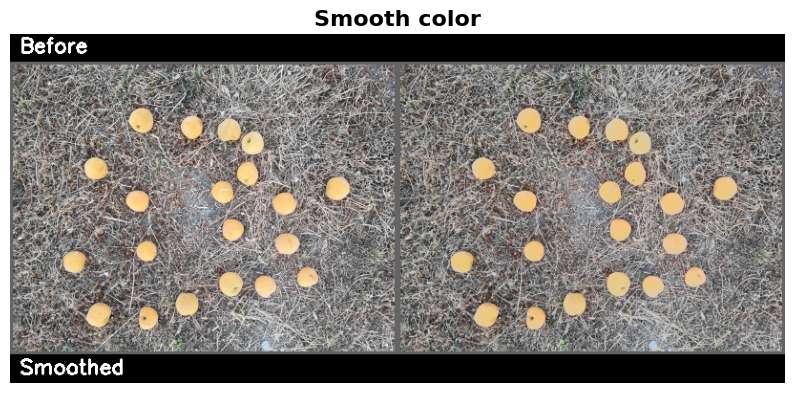

   Remove Texture 1:
1.2. Amplify Color:
    Skipping Amplify Color
2. Blur:
   Remove Texture 2:
3. Select Foreground
    .
    .
    .
    .


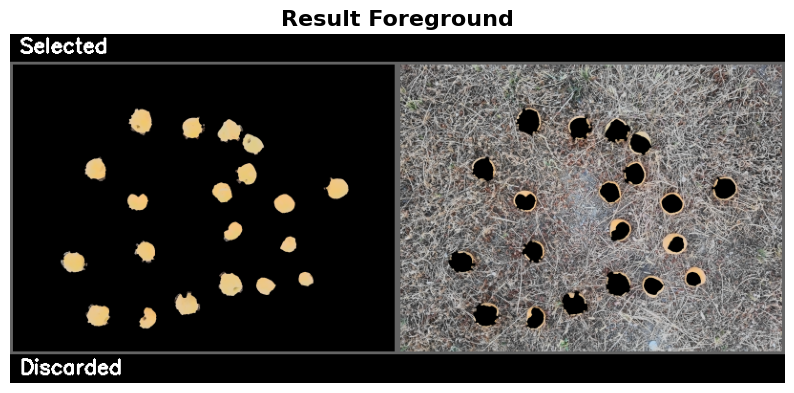

   Remove Texture 3:


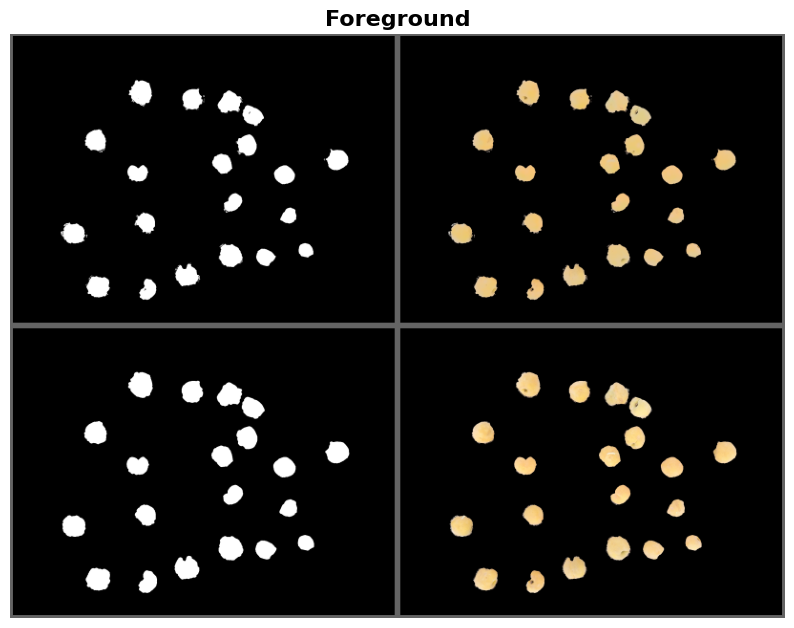

3.1. Quantization:
Applying KMeans
Coloring Viridis
Recoloring based on original
KMeans finished


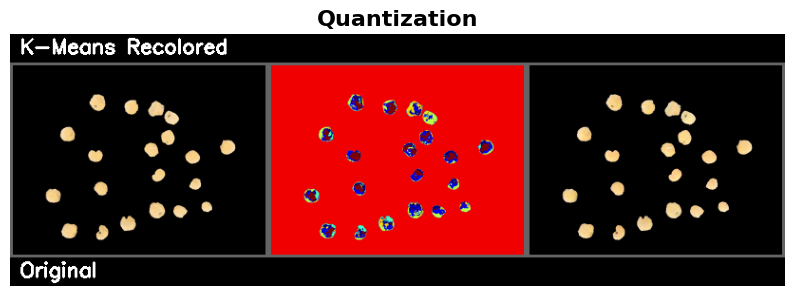

4. Select object:
    .
    .


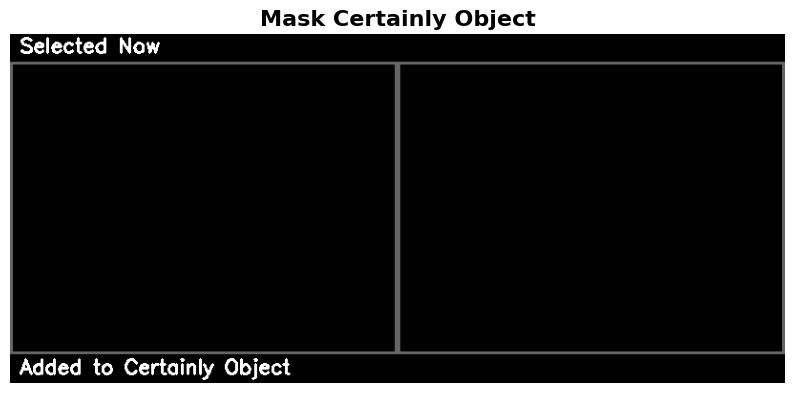

    .


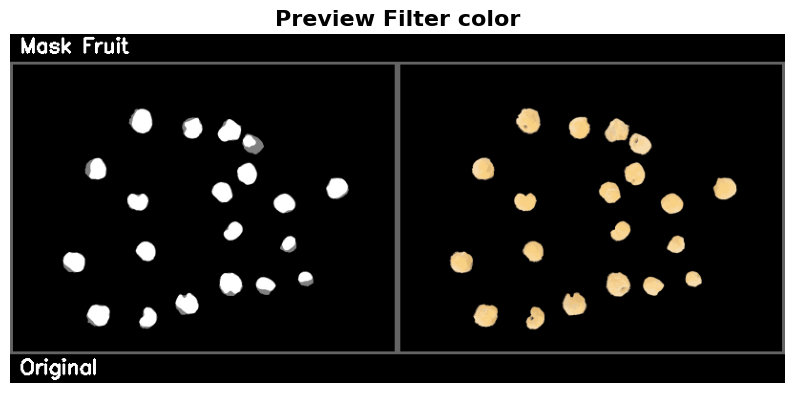

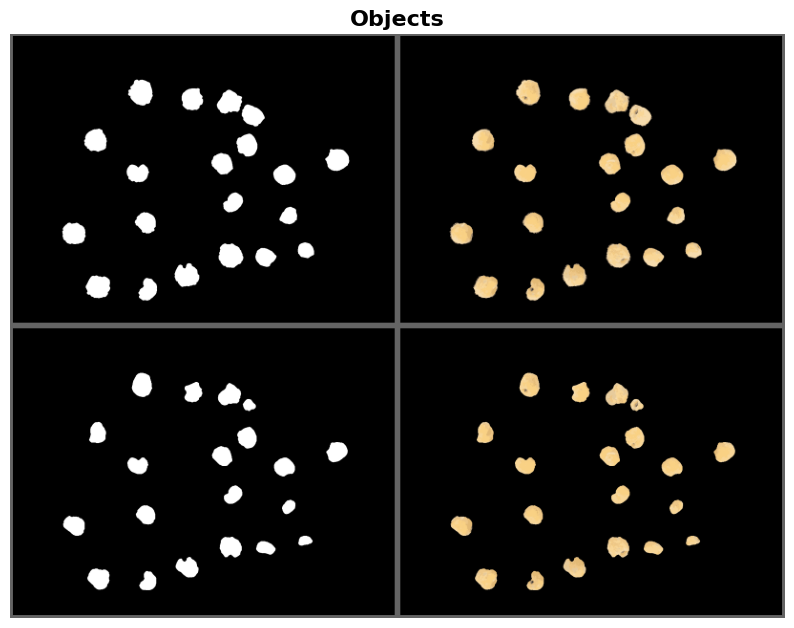

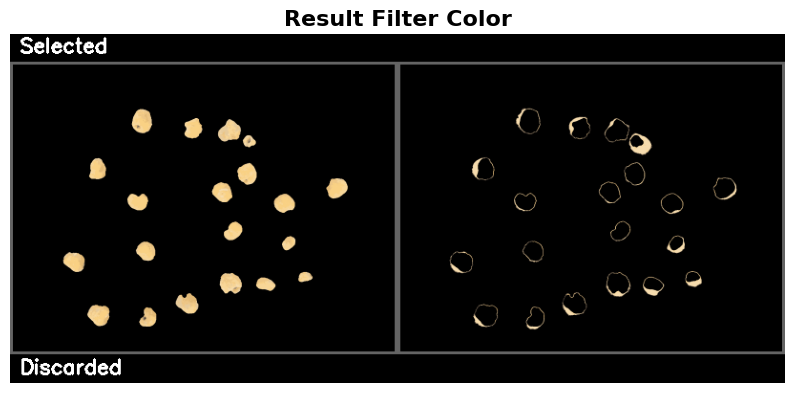

   Remove Texture 4:
   Skipping Texture 4
6. Blur mask:


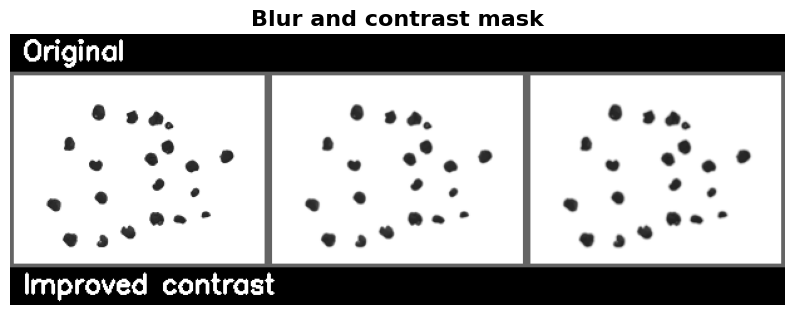

6.1. Fill holes:


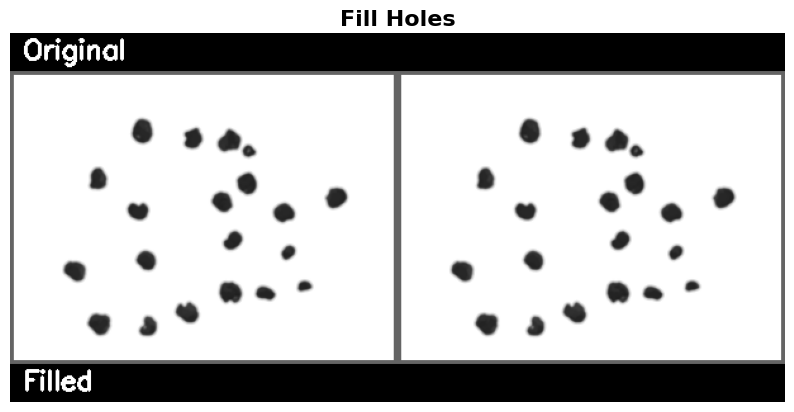

7. Detect Circles:
    Turn 0: 11 circles detected.
    Turn 1: 19 circles detected.
    Turn 2: 8 circles detected.
    Turn 3: 0 circles detected.
    Turn 4: 0 circles detected.
   Last attempt to detect circles.
    Turn 5: 0 circles detected.
    38 circles detected before remove overlap.
    19 circles detected after remove overlap.
8. Final Result
    Found=19 objects     Expected=20    Accuracy=95.0%    Filename=peach_yellow_104_gt20.jpg
Final Result:


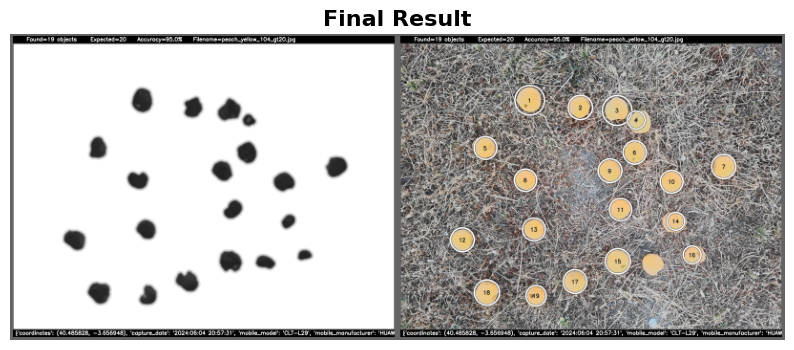

9. Saving files
    Saved: /kaggle/input/fruit-count/test_images/peach_yellow_104_gt20.jpg_result_pd=[19]acc=[95.0pct].jpg
    Original Image Reduced: (2736, 3648, 3)    New Size: (1536, 2048, 3)
Print configuration



10. Calculating Result JSON:
EXIF={256: 3648, 257: 2736, 258: (8, 8, 8), 34853: {0: b'\x02\x02\x00\x00', 1: 'N', 2: (40.0, 29.0, 8.982238), 3: 'W', 4: (3.0, 39.0, 25.011405), 5: b'\x00', 6: 745.2, 7: (18.0, 57.0, 30.0), 27: 'CELLID', 29: '2024:06:04'}, 296: 2, 34665: 284, 41995: b'ipp\x00', 271: 'HUAWEI', 272: 'CLT-L29', 305: 'CLT-L29 12.0.0.225(C432E5R1P1)', 274: 0, 306: '2024:06:04 20:57:31', 531: 1, 282: 72.0, 283: 72.0, 36864: b'0210', 37121: b'\x01\x02\x03\x00', 37122: 0.95, 36867: '2024:06:04 20:57:31', 36868: '2024:06:04 20:57:31', 37377: 29.8973, 37378: 1.69, 37379: 0.0, 37380: 0.0, 37381: 1.69, 37383: 5, 37384: 1, 37385: 0, 37386: 5.58, 40961: 1, 40962: 3648, 37520: '207395', 37521: '207395', 37522: '207395', 40963: 2736, 41996: 0, 41495: 2, 41728: b'\x03', 3343

100%|██████████| 1/1 [00:05<00:00,  5.49s/it]

Image with dimensions: 2736x3648px:
GPS Coordinates: lat=40.485828, long=-3.656948
Photo taken on: 2024:06:04 20:57:31
Mobile Device: CLT-L29 / HUAWEI.
Found 19 objects.
Accuracy: 95.0
Ground truth: 20
directory=/kaggle/input/fruit-count/test_images
Average Error of YELLOW_PEACH : 5.0% out of 1 images
directory=/kaggle/input/fruit-count/test_images
Average Error of YELLOW_PEACH : 5.0% out of 1 images


In [242]:
# Detailled test:
BATCH_MODE = True
PRINT_REPORT_ON_IMAGE = True

TUNNING_BLUR = False
TUNNING_TEXTURE = False
TUNNING_FOREGROUND = False
TUNNING_OBJECT = False
TUNNING_CIRCLES = False
DEBUG_LEVEL = 3
WAIT_TIME = 0

accuracy_summaries = []
accuracy_summaries.append(test_directory(r"/kaggle/input/fruit-count/test_images", 'YELLOW_PEACH ', limit_files=1))

for summary in accuracy_summaries:
    debug_print(summary)

  0%|          | 0/11 [00:00<?, ?it/s]

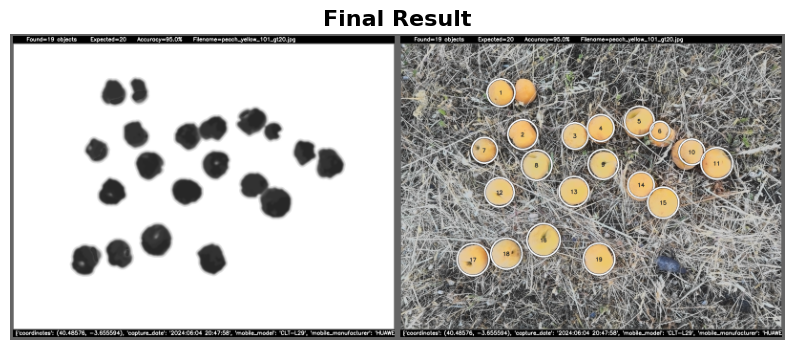

 18%|█▊        | 2/11 [00:03<00:13,  1.54s/it]

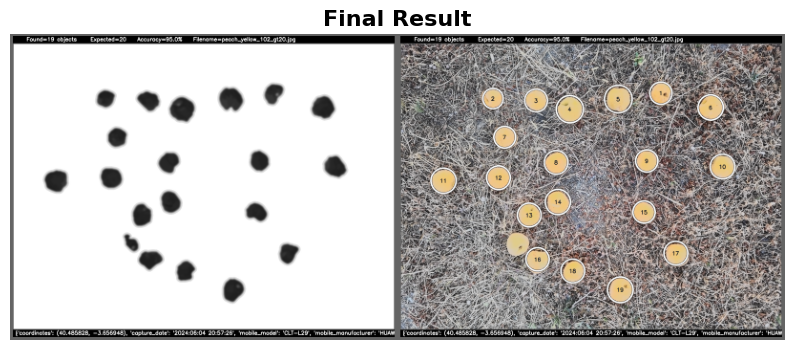

 27%|██▋       | 3/11 [00:06<00:17,  2.22s/it]

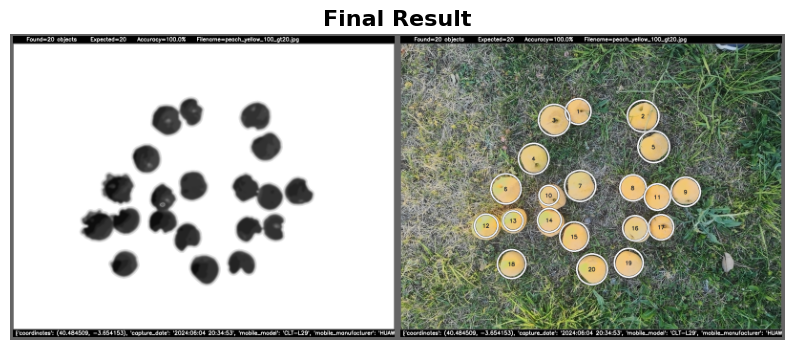

 36%|███▋      | 4/11 [00:09<00:17,  2.53s/it]

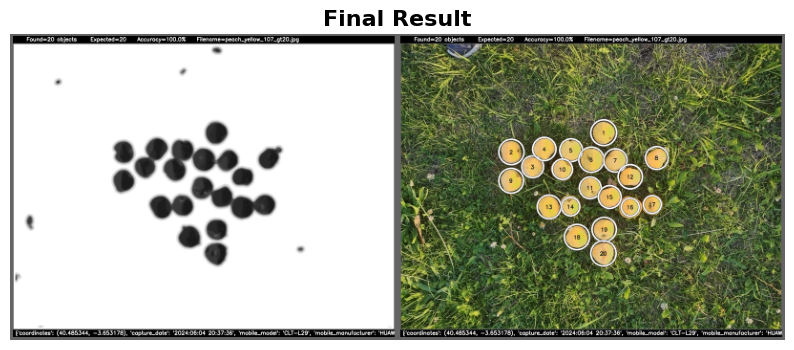

 45%|████▌     | 5/11 [00:12<00:17,  2.87s/it]

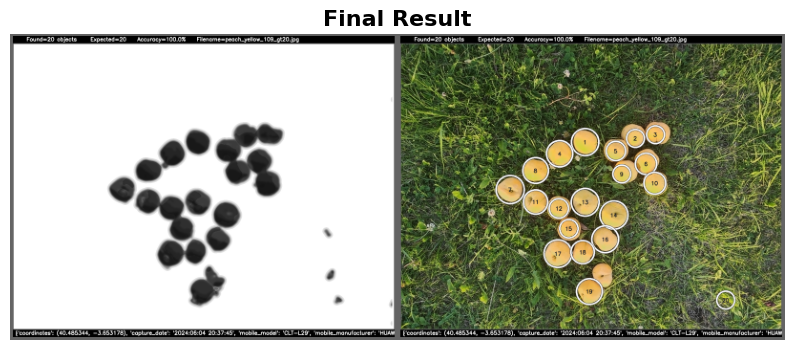

 55%|█████▍    | 6/11 [00:15<00:14,  2.94s/it]

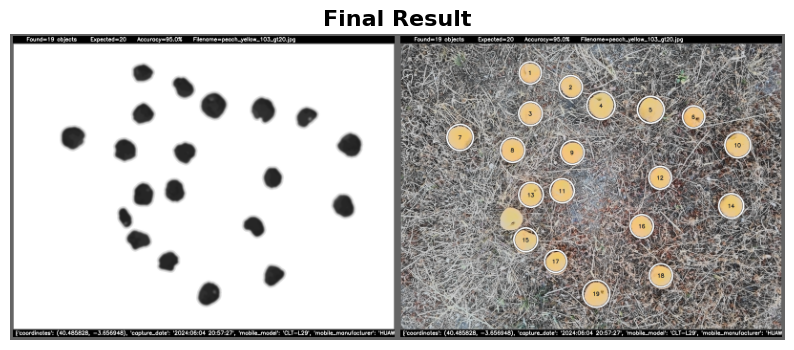

 64%|██████▎   | 7/11 [00:18<00:11,  2.94s/it]

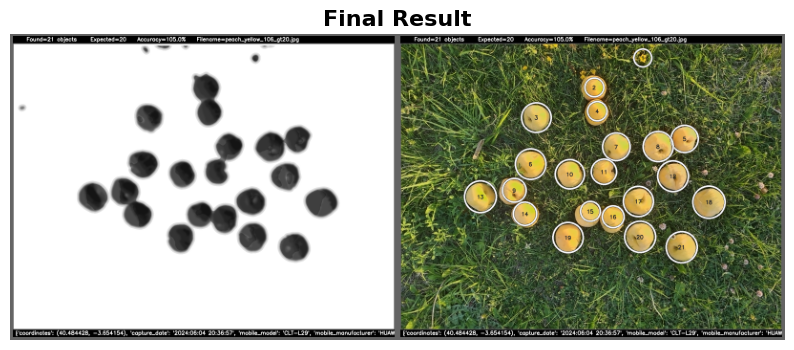

 73%|███████▎  | 8/11 [00:21<00:08,  2.96s/it]

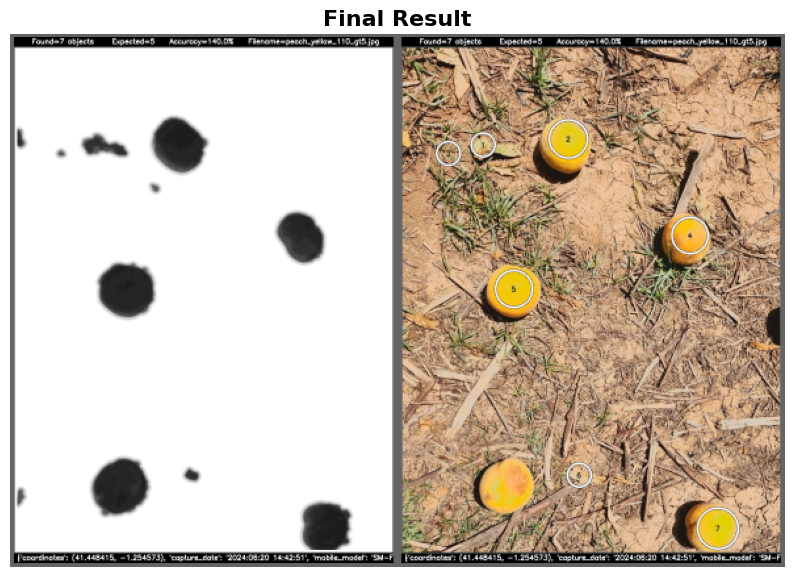

 82%|████████▏ | 9/11 [00:24<00:05,  2.95s/it]

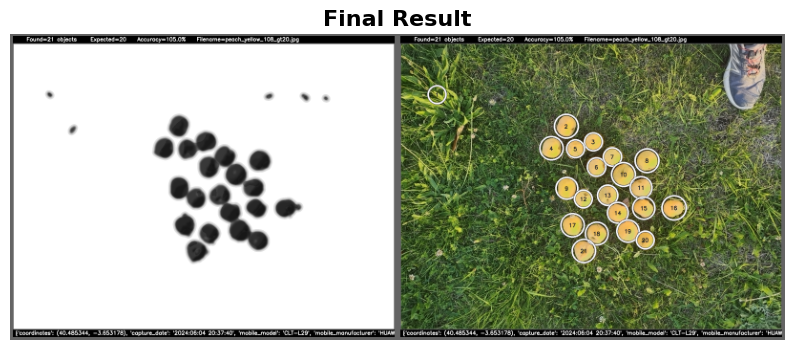

 91%|█████████ | 10/11 [00:27<00:02,  2.94s/it]

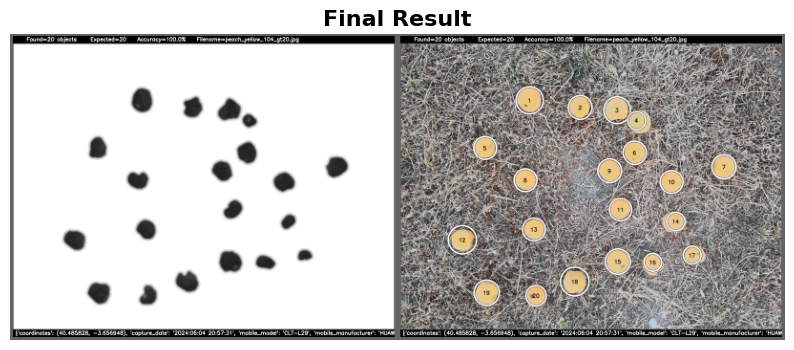

100%|██████████| 11/11 [00:30<00:00,  2.94s/it]

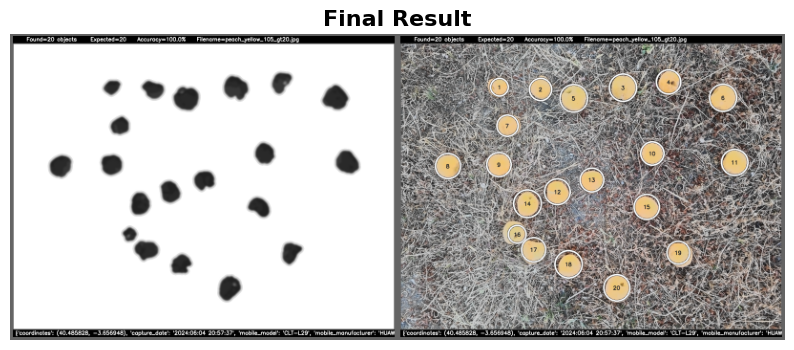

100%|██████████| 11/11 [00:33<00:00,  3.05s/it]


In [243]:
# Batch test:

DEBUG_LEVEL = 5
WAIT_TIME = 1
TUNNING_BLUR = TUNNING_TEXTURE = TUNNING_FOREGROUND = TUNNING_OBJECT = TUNNING_CIRCLES = False

    
DEBUG_LEVEL = 1
accuracy_summaries = []

accuracy_summaries.append(test_directory(r"/kaggle/input/fruit-count/test_images", 'YELLOW_PEACH '))

for summary in accuracy_summaries:
    debug_print(summary)